# Modeling Volatility with GARCH Class Models
### References:
- V-Lab. https://vlab.stern.nyu.edu/zh
- Autoregressive conditional heteroskedasticity.https://en.wikipedia.org/wiki/Autoregressive_conditional_heteroskedasticity
- arch lib.https://arch.readthedocs.io/en/latest/
- Value-at-Risk Theory and Practice.https://www.value-at-risk.net/ccc-garch/
- Amath 546/Econ 589 Multivariate GARCH Models https://faculty.washington.edu/ezivot/econ589/multivariategarch.pdf
- Detailed Mathmatical Proof: Dynamic Conditional Correlation: a simple class of multivariate GARCH models.https://pages.stern.nyu.edu/~rengle/dccfinal.pdf
- R-code demonstation: Amath 546/Econ 589 DCC GARCH DCC GARCH.https://faculty.washington.edu/ezivot/econ589/DCCgarchPowerpoint.pdf


### Volatility(Risk) Application: 
  - Option pricing: Black-Scholes model's fundamental theory
  - Risk management: VaR, the Sharpe Ratio, BARRAR, IVOL in Fama-French Three Factor Model.
  - Trading: VIX


- Volatility Clustering: Large changes tend to follow by large changes, small changes trend to follow by small changes.

## ARCH(p): Autoregressive Conditional Heteroskedasticity
- Conditional heteroskedasticity: an increase in volatility is correlated with a *further* increase in volatility.
- Intution: <u>variance of current error term</u> as a function of actual size of <u>previous</u> time periods' error terms. 
- Suitable Condition: when the error variance in time series follows AR model
- Formula: $Var(x_t)=\sigma_t^2=w+\alpha_1ϵ_{t-1}^2+...+\alpha_pϵ_{t-p}^2=w+\sum_{i=1}^p \alpha_i ϵ_{t-i}^2$
  - $ϵ_t=\sigma_t z_t$, where $z_t \sim N(0,1) iid$
    - has white noise properties$\sim dist(0,\sigma_t^2)$, time dependent variation
    - serially uncorrelated, but not serially independent
    - subjected to Ljung-Box Q test
  - $r_t=\mu + ϵ_t$
    - return series equal to expected return and `unexpected return`(mean-corrected return, error term, innovations)$ϵ_t$
  - $p$: length of lag, process order
- Hypothesis:
  - $H_0$: we have $\alpha_i=0$ for all $i=1,2,...,p$,in absence of ARCH process
  - $H_1$: in presence of ARCH componenets, **at least one** of estimated $\alpha_i$ must be **significant**.
- In this case, we use Google 2017~2022 daily stock price to apply ARCH(1).

In [1]:
!pip install arch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
from arch import arch_model
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
import warnings
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

In [6]:
#declare some variables
riskyAsset='GOOG'
SD='2017-01-01'
ED='2022-12-31'

In [7]:
#download data from yfinance
GOOG=yf.download(riskyAsset,start=SD,end=ED,progress=False)

In [8]:
GOOG.head()

Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2017-01-03  38.940498  39.481499  38.790001  39.306999  39.306999  33146000
2017-01-04  39.417999  39.567001  39.158001  39.345001  39.345001  21460000
2017-01-05  39.304001  39.723999  39.250999  39.701000  39.701000  26704000
2017-01-06  39.763000  40.395000  39.610199  40.307499  40.307499  32804000
2017-01-09  40.320000  40.498299  40.141499  40.332500  40.332500  25492000

<AxesSubplot:title={'center':'GOOG Returns: 2017-01-01 - 2022-12-31'}, xlabel='Date'>

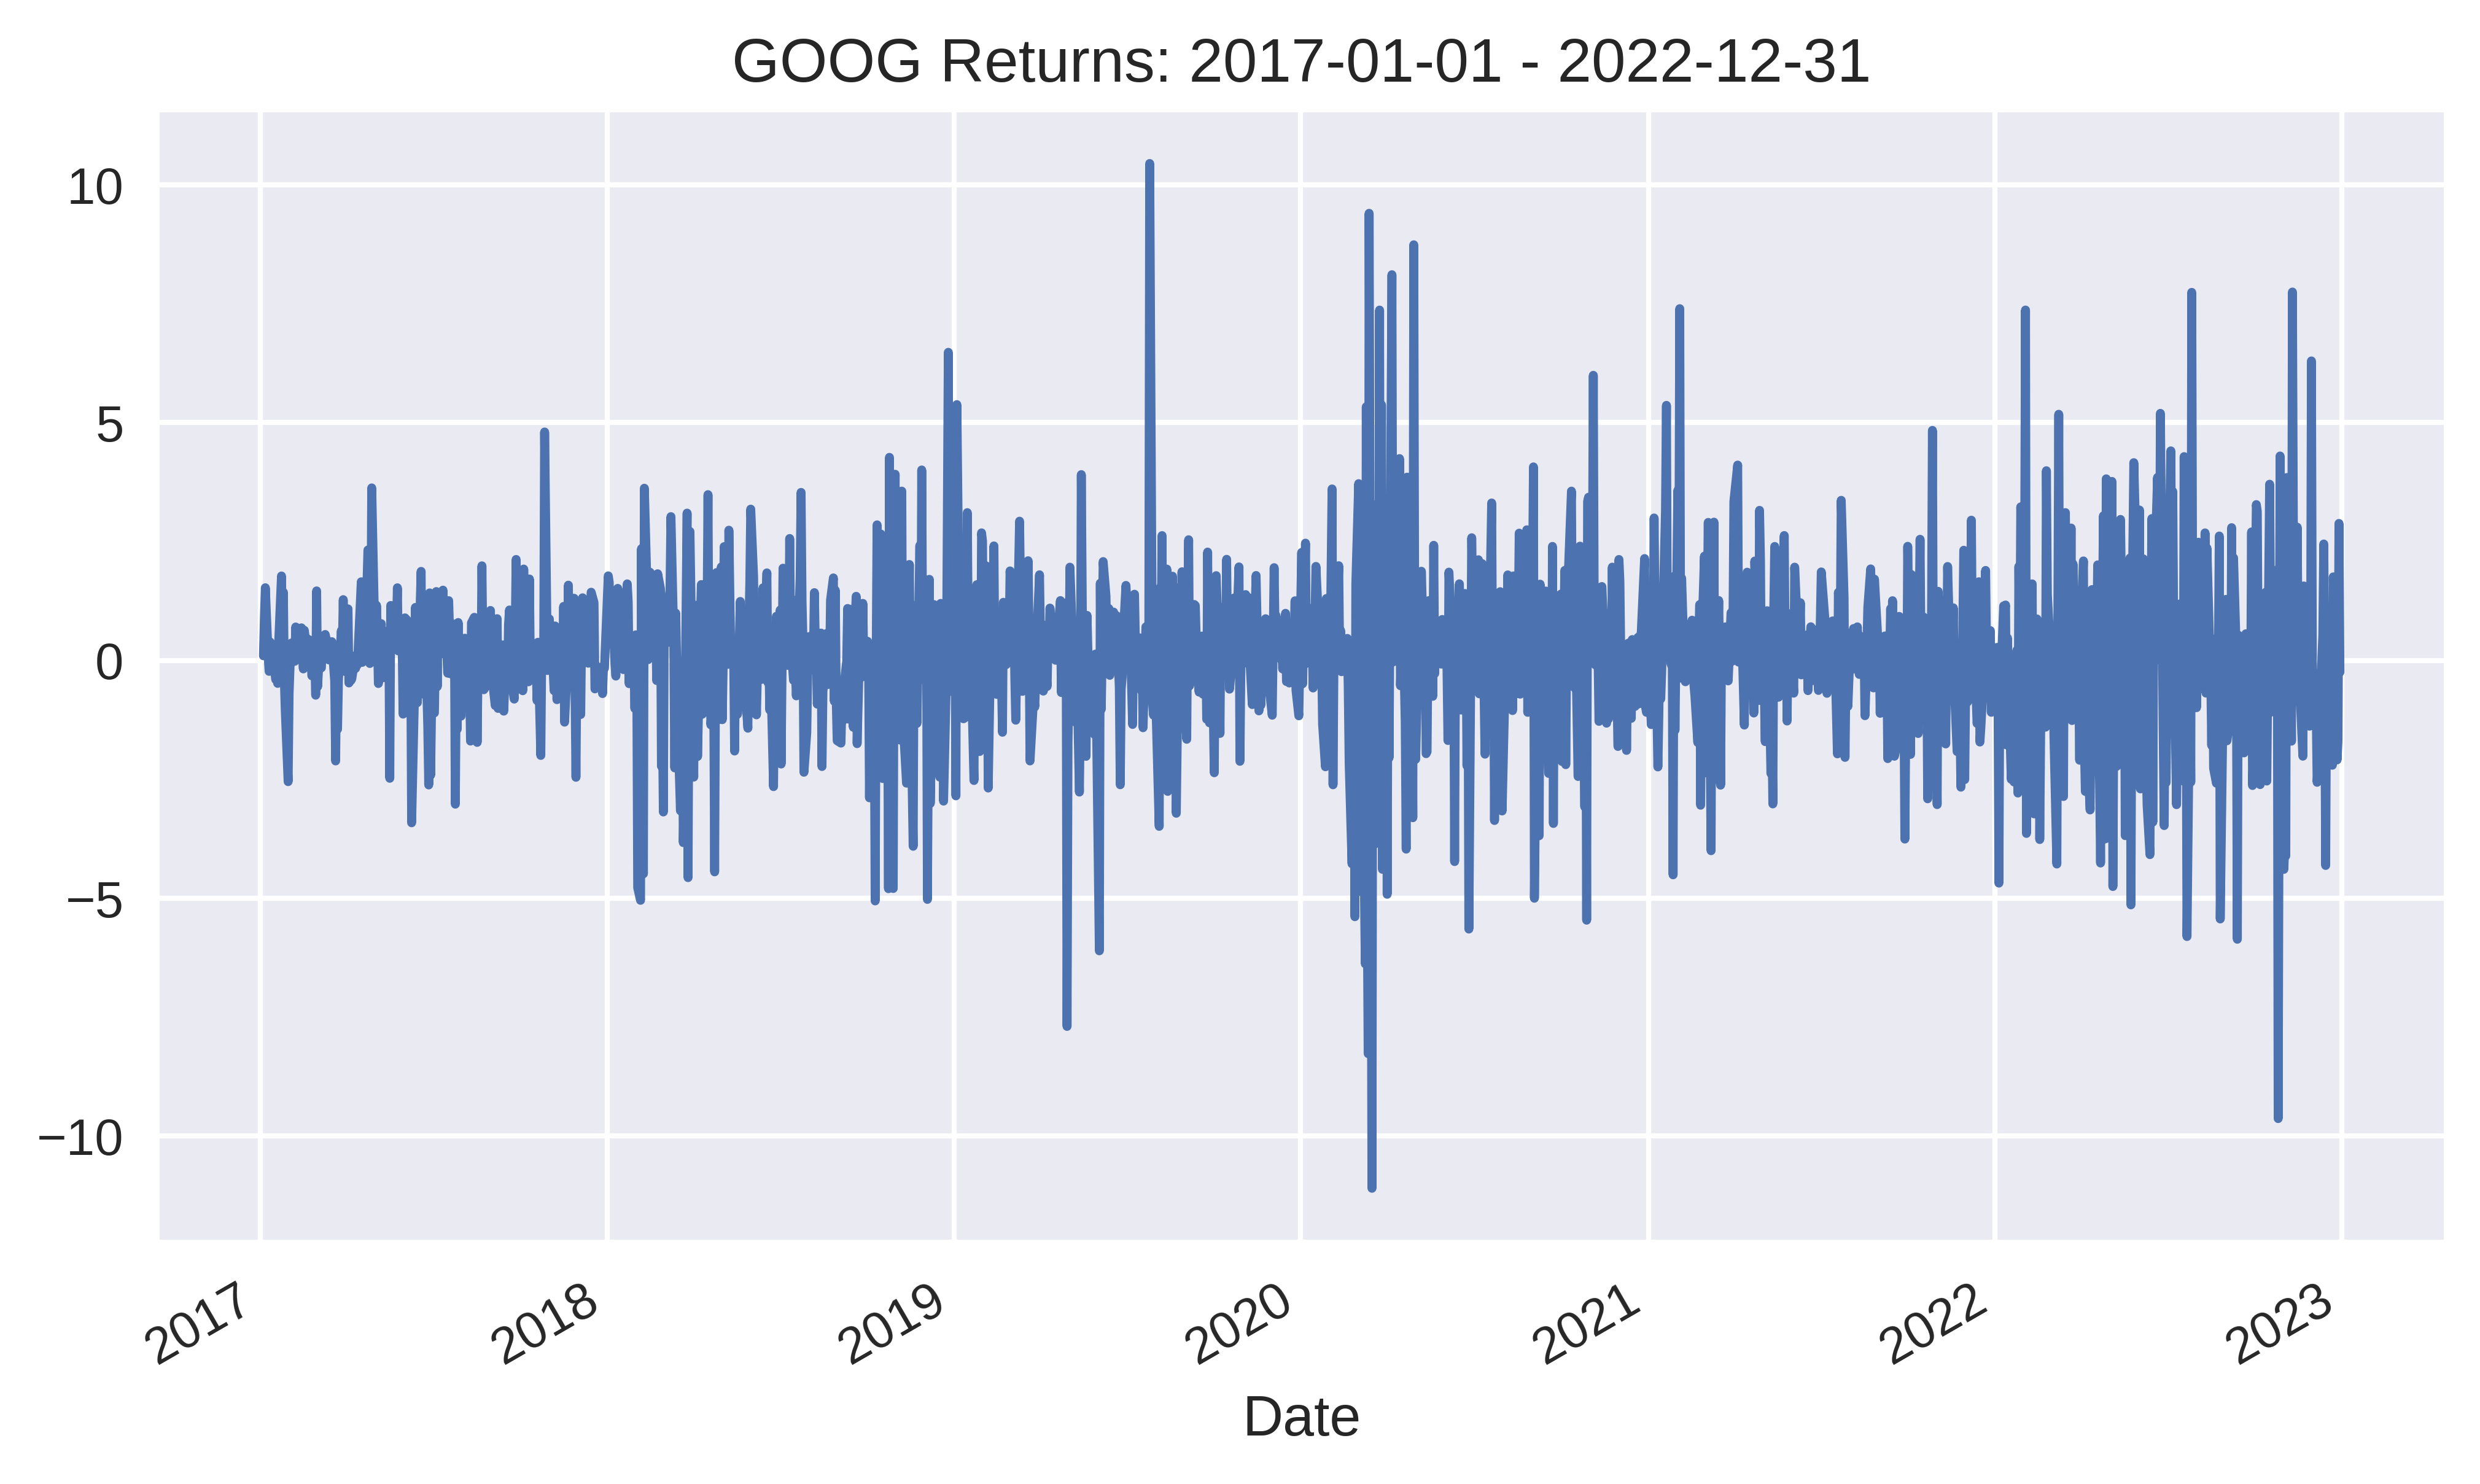

In [9]:
#data processing:calculate the daily return, rename, and visualization 
returns=100 * GOOG['Adj Close'].pct_change().dropna() #*100 to express them in percentage format
returns.name='daily_return'
returns.plot(title=f'{riskyAsset} Returns: {SD} - {ED}')

From the graph, we can see the volatility clustering and some sudden spikes.

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment

def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    x.plot(ax=axes[0][0], title='Residuals')
    x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=14)
    sns.despine()
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

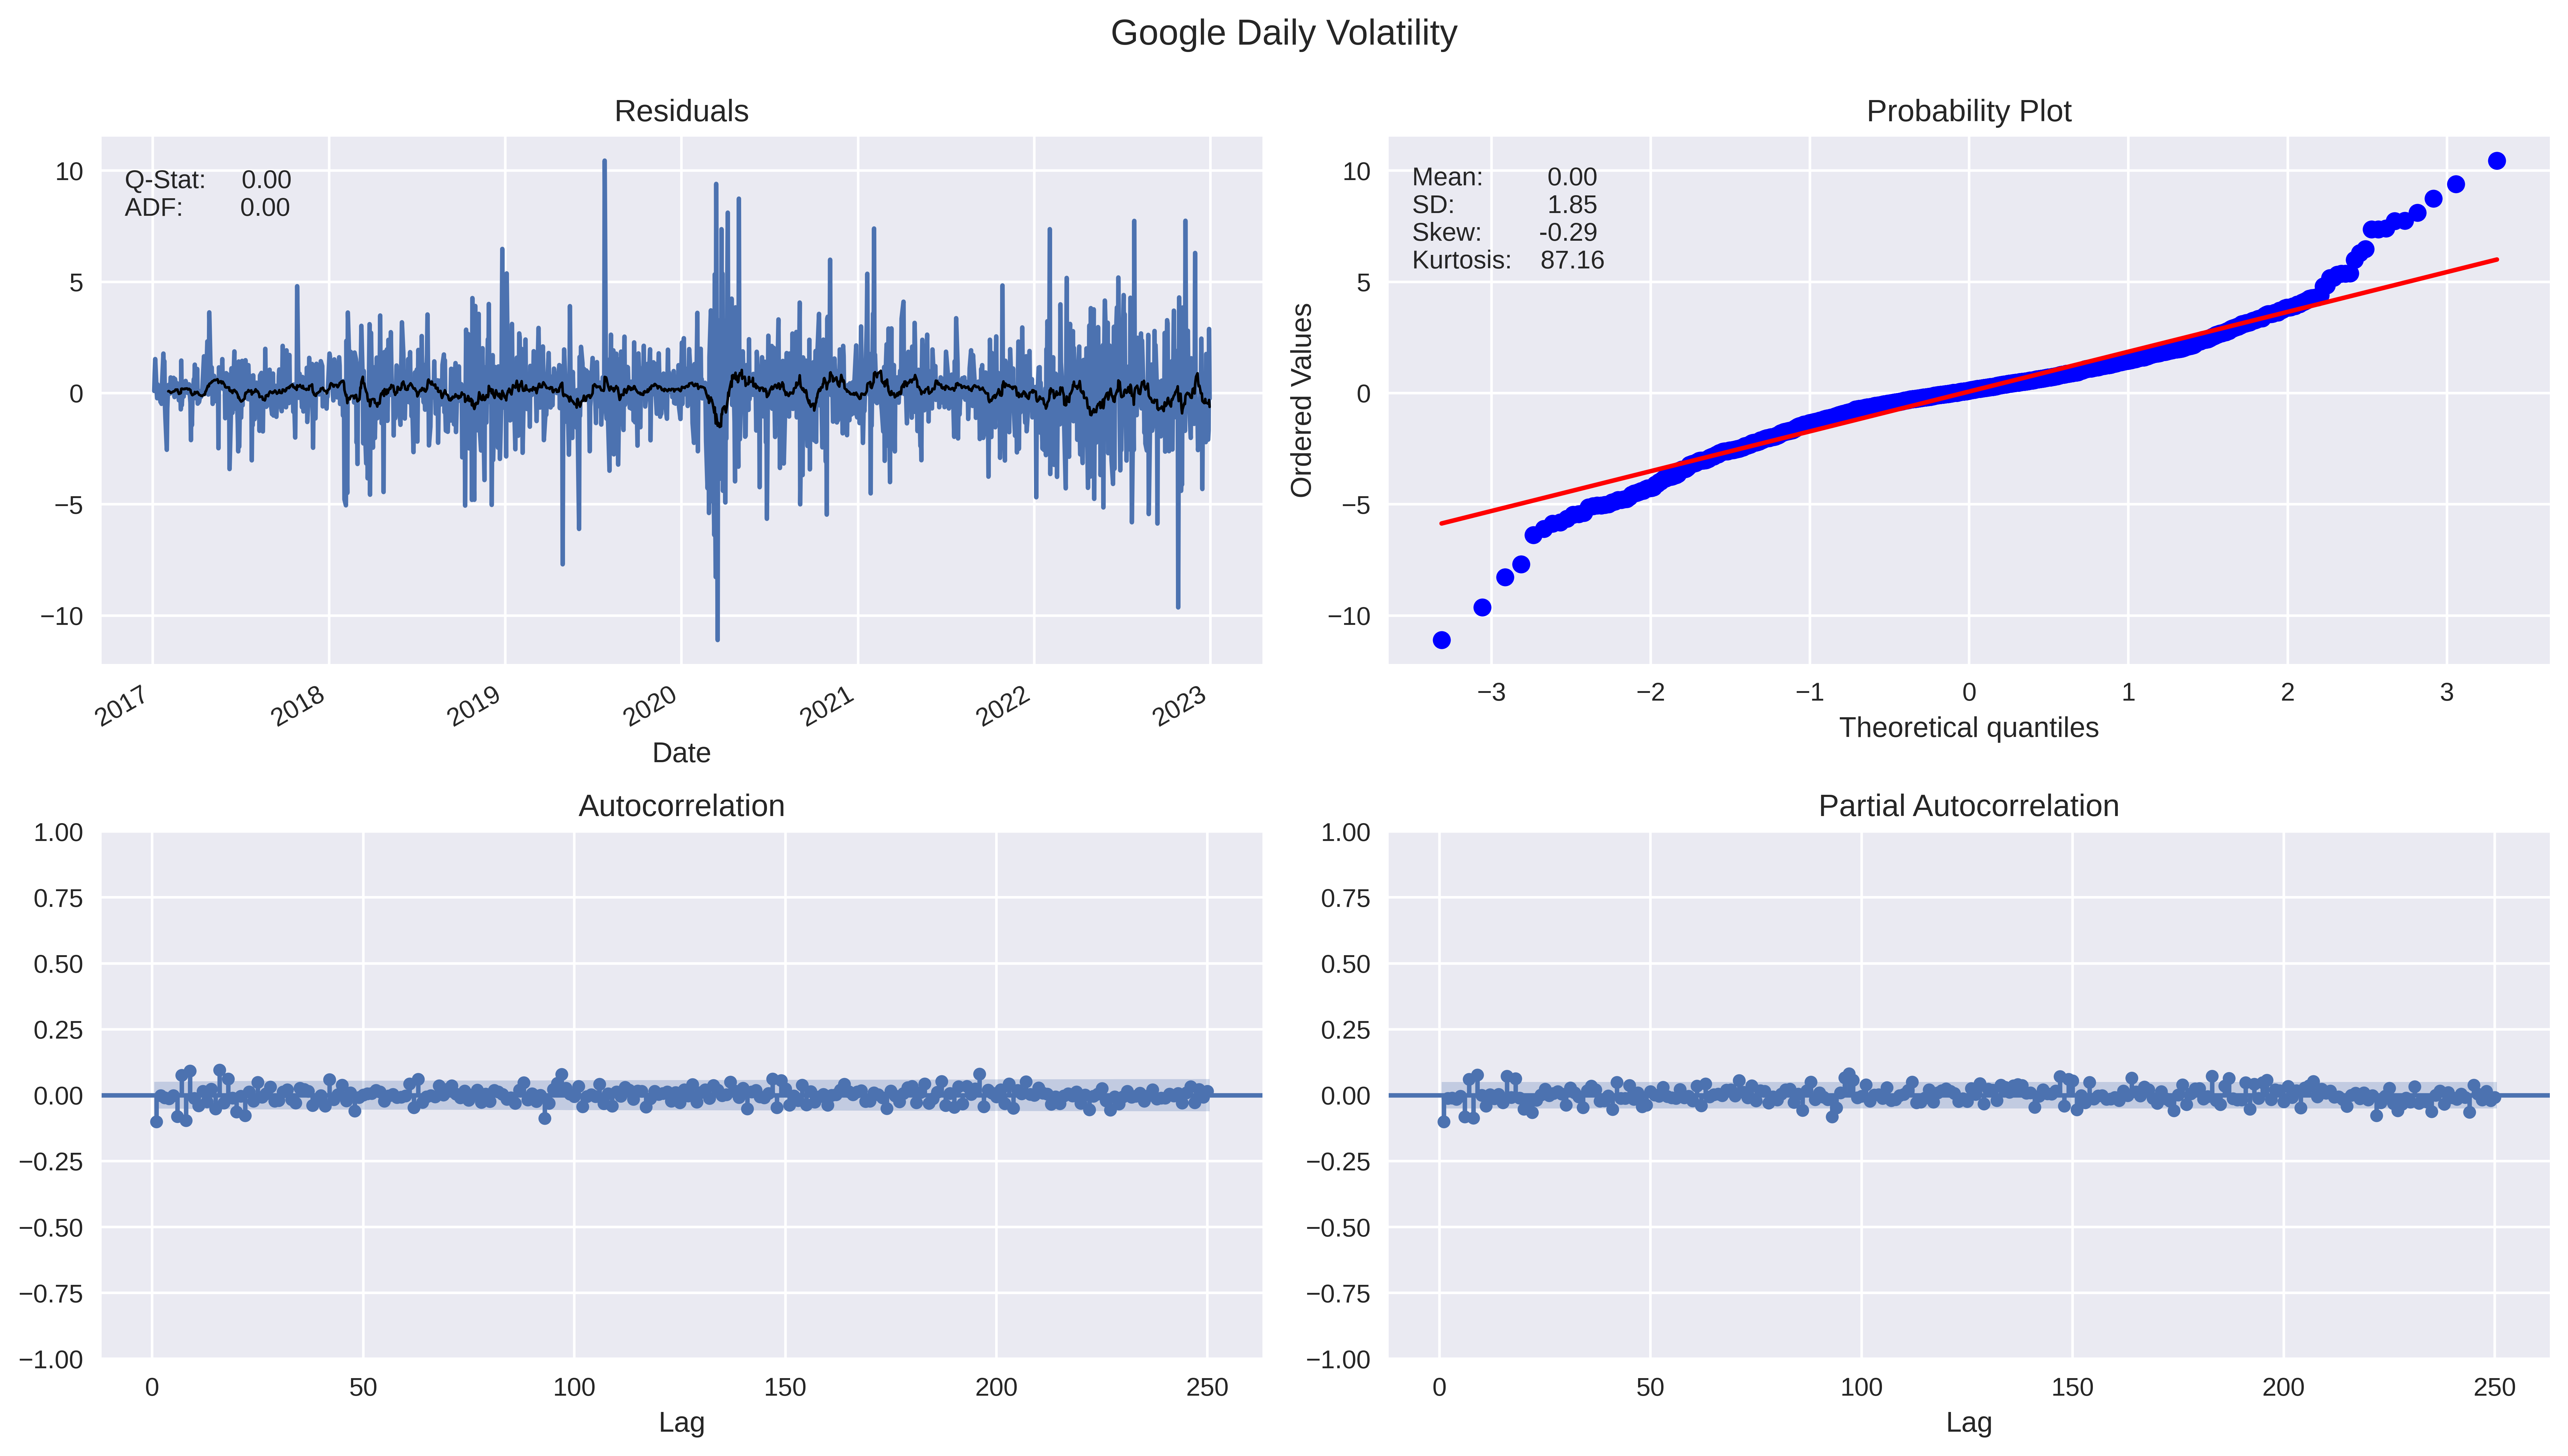

In [11]:
plot_correlogram(returns, lags=250,title='Google Daily Volatility')

In [12]:
#modeling with ARCH
ARCH=arch_model(returns, mean='Zero', vol='ARCH', p=1, o=0, q=0) #zero-mean approach is suitable for many liquid financial assets.
# Another choice for conditional mean method:  mean constant, variants of ARIMA, 

In [13]:
#model training and print the summary
result=ARCH.fit(disp='off') #disp='off': suppress output from the optimization steps, for overcoming convergence when the values are too small.
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Zero Mean - ARCH Model Results                        
==============================================================================
Dep. Variable:           daily_return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                       ARCH   Log-Likelihood:               -3011.37
Distribution:                  Normal   AIC:                           6026.75
Method:            Maximum Likelihood   BIC:                           6037.38
                                        No. Observations:                 1509
Date:                Fri, Mar 10 2023   Df Residuals:                     1509
Time:                        02:47:19   Df Model:                            0
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          2.4862      0.219     11.375  5.601e-30 [  2.058,  2.915]
alpha[1]       0.3010  7.973e-02      3.776  1.595e-04 [  0.145,  0.457]
========================================================================

Covariance estimator: robust
"""

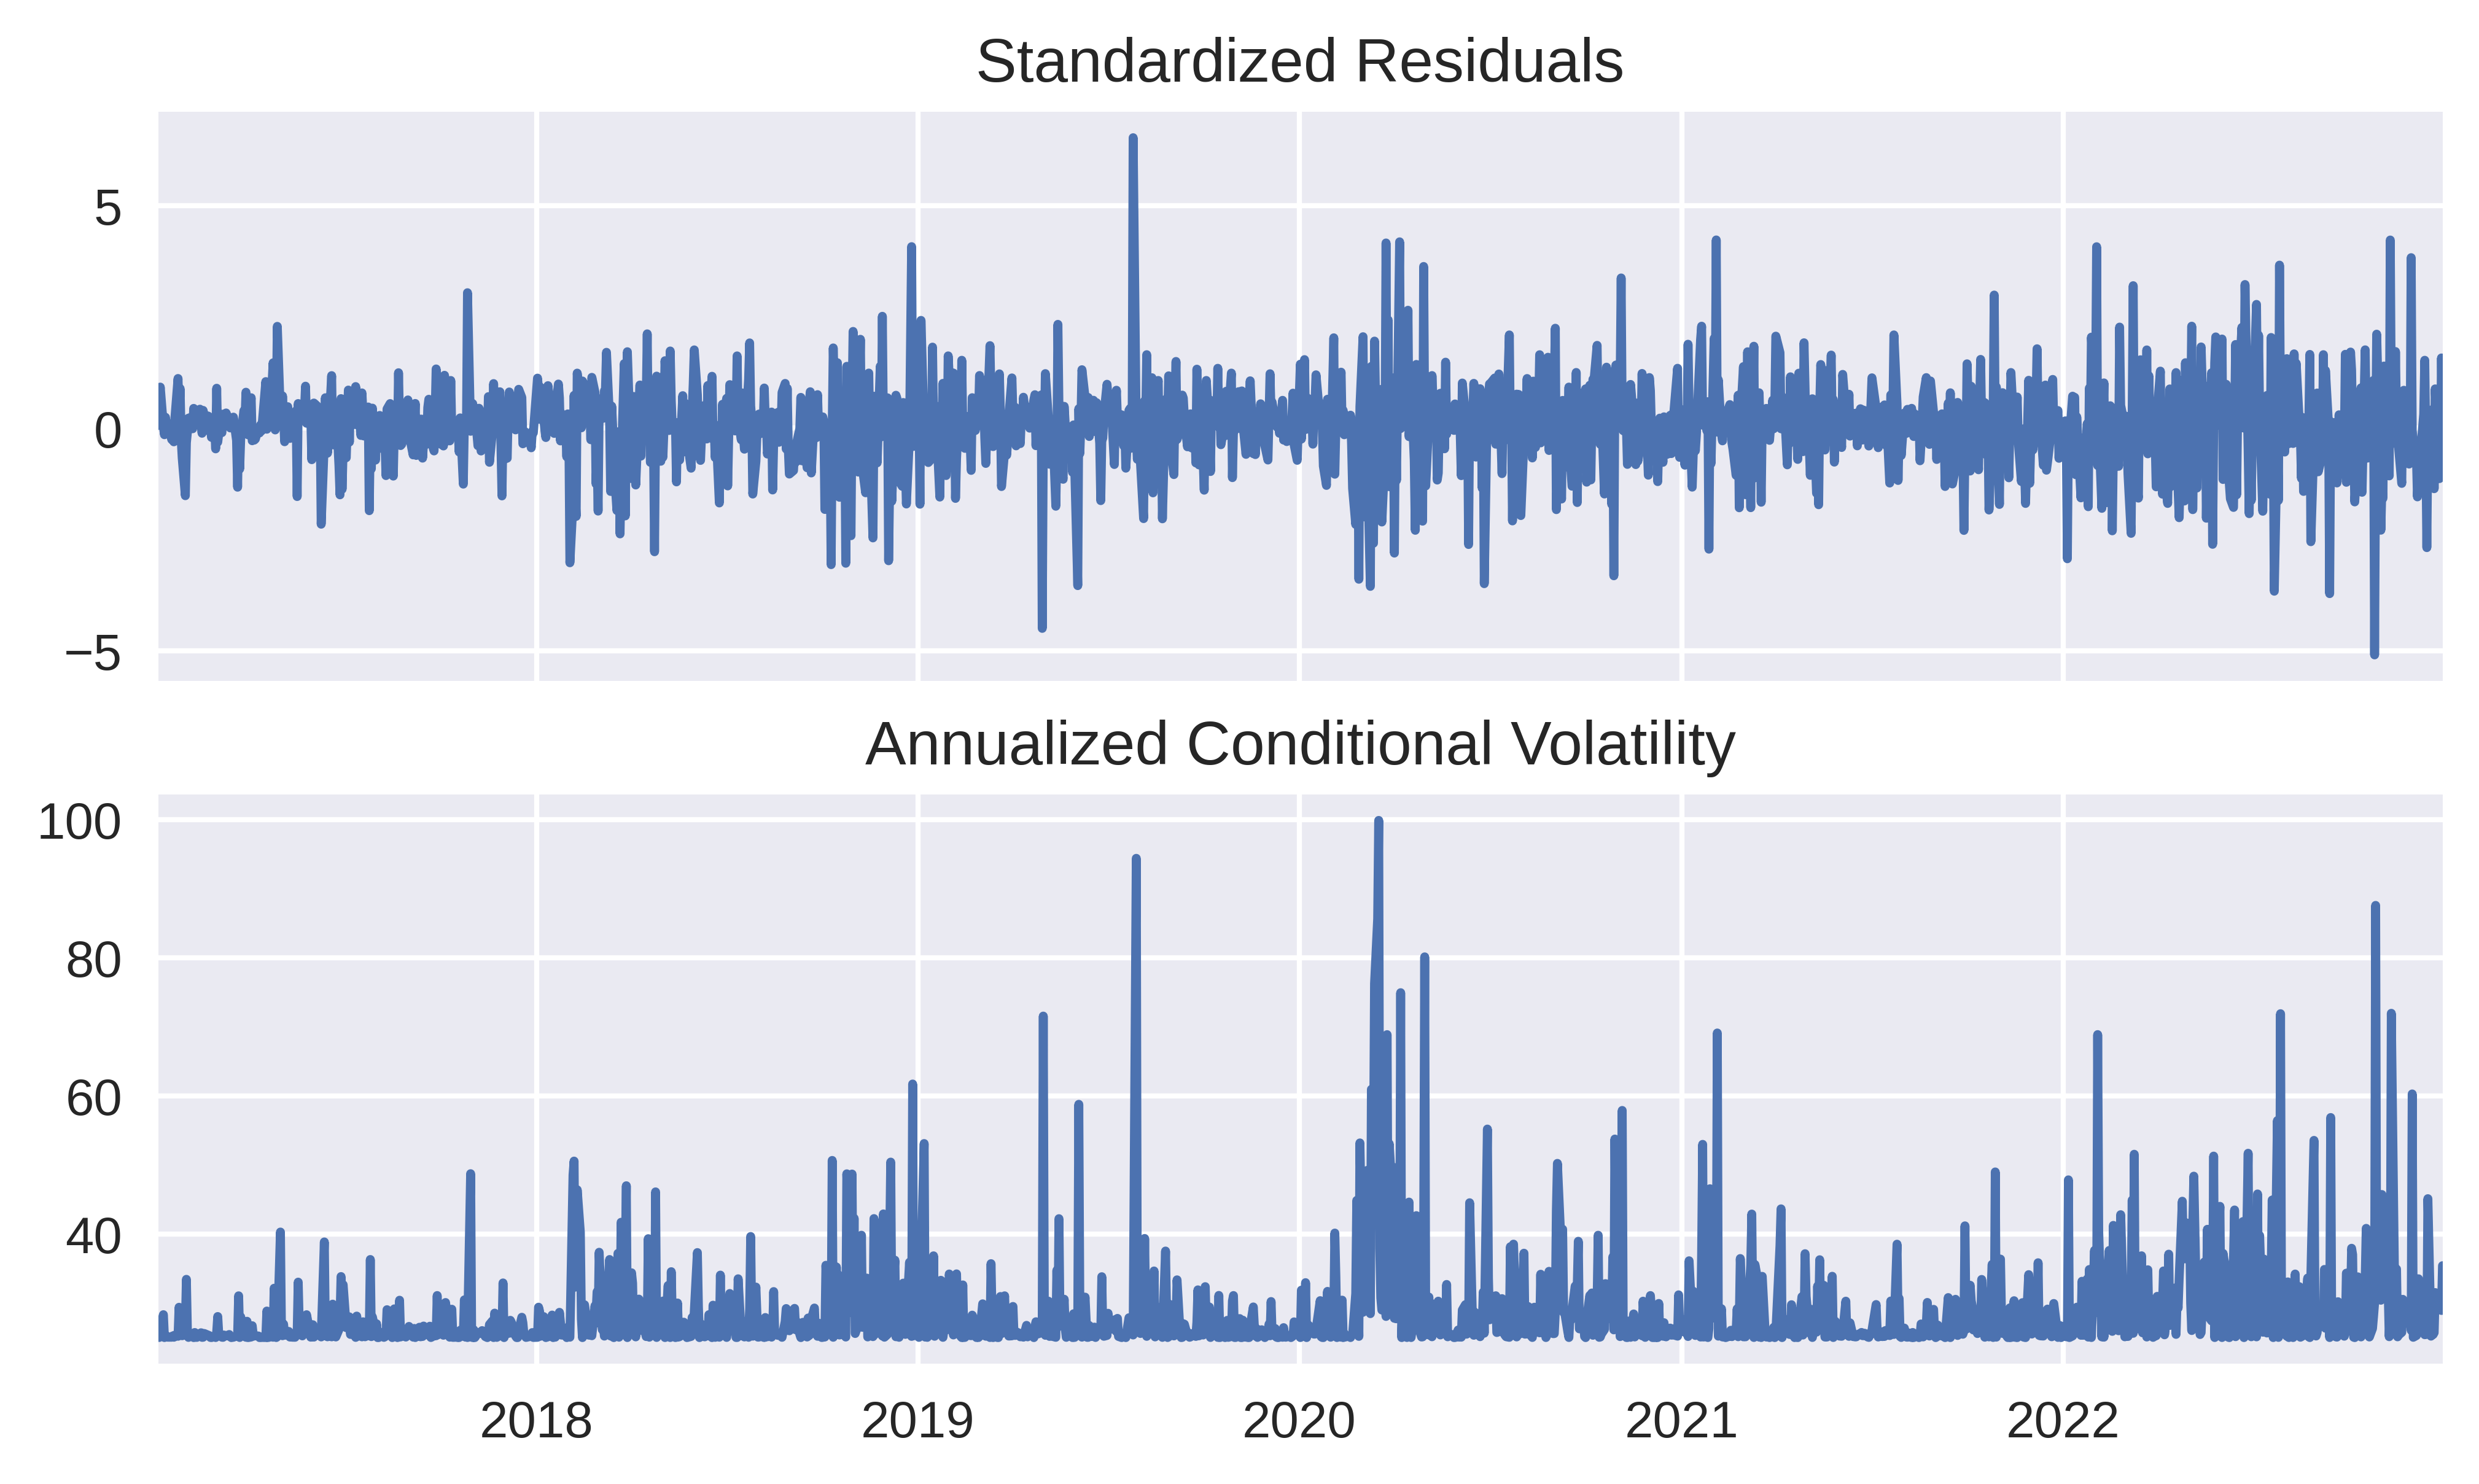

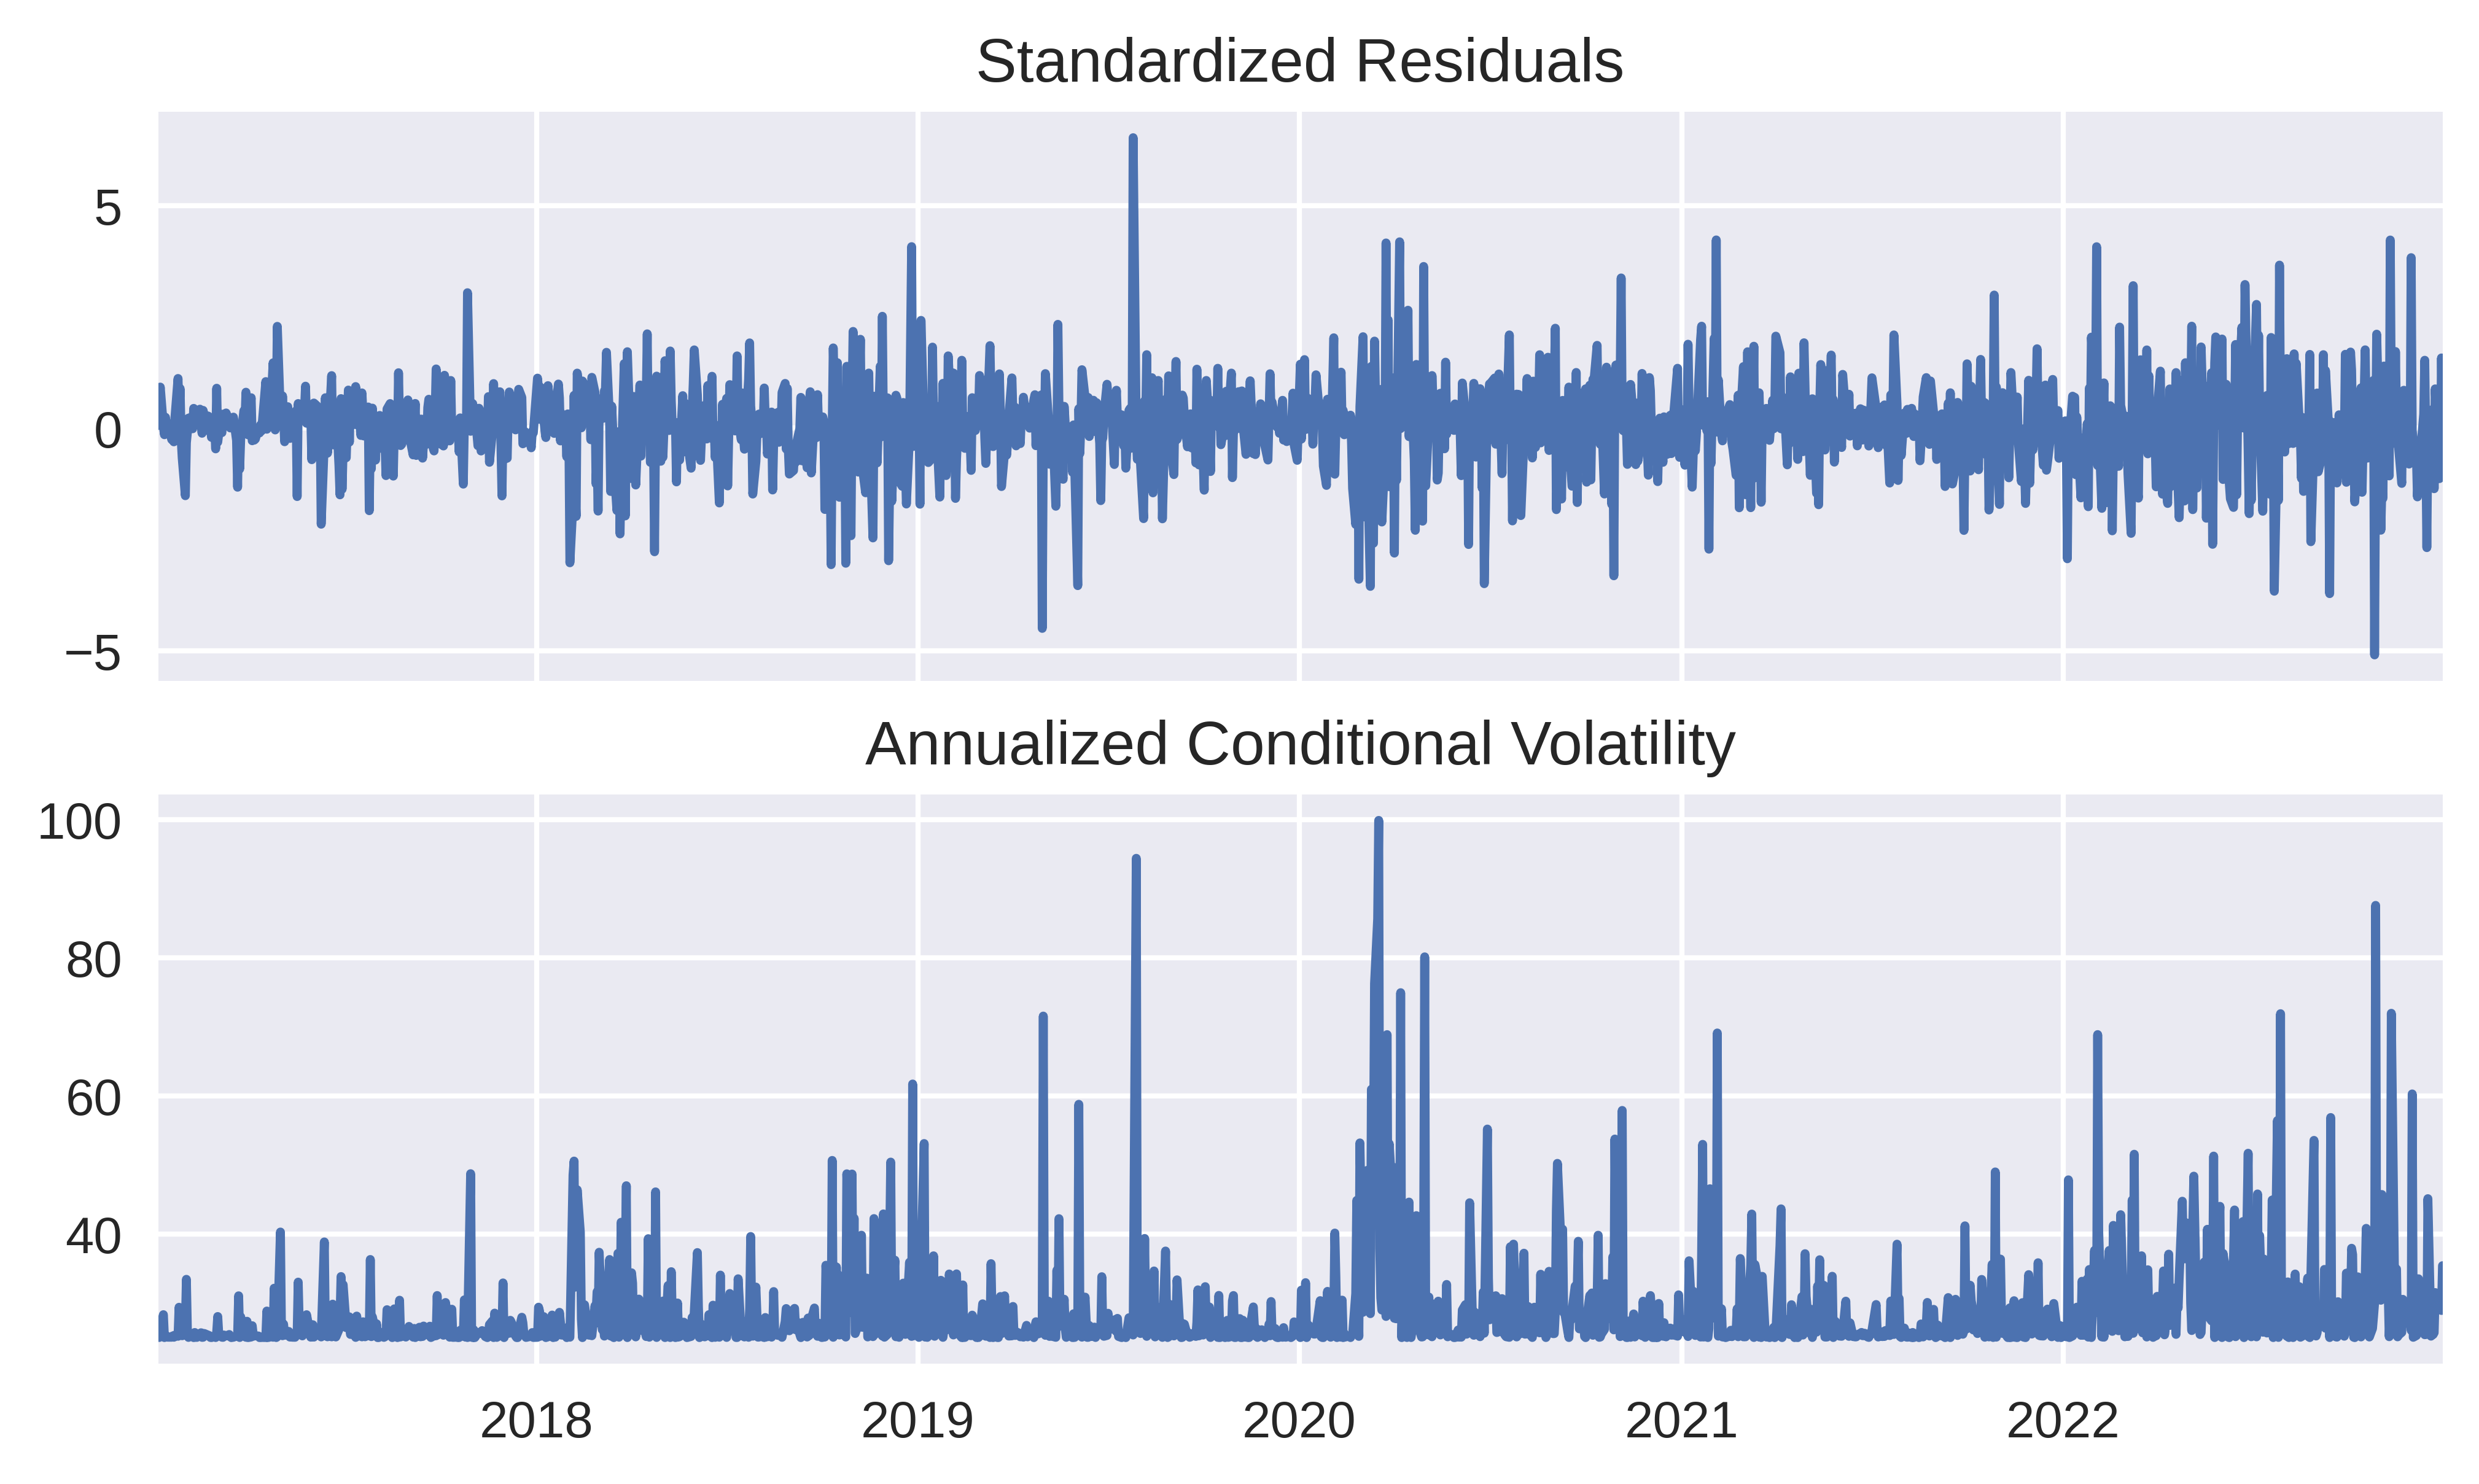

In [14]:
#plot the residuals and conditional volatility
result.plot(annualize='D') #annualize the conditional volatility series from daily data.
#Standardized residuals were computed by dividing the residuals by the conditional volatility.

#### Conditional Variance:
Variance of a random variable given the value(s) of one or more other variables.

###  Lagrange Multiplier (LM, Score) Test, Test for ARCH Effect
- To check whether the some parameter resitrictions are violated.
- Hypothesis: $H_0$: the coefficients are 0 of any order up to p. There are no ARCH effects.$\alpha_0=\alpha_1=\alpha_2...=\alpha_p=0$
- LM test statistics: $T*R^2 \sim \chi^2(p)$, where degree of freedom of chi-square distribution is p.
  - T: numbers of observations
- python lib: `statsmodels.stats.diagnostic.het_arch`

In [15]:
from statsmodels.stats.diagnostic import het_arch
from statsmodels.stats.diagnostic import acorr_ljungbox

In [16]:
#get the residuals from ARCH model
resid = result.resid

In [17]:
resid.head()

Date
2017-01-04    0.096680
2017-01-05    0.904814
2017-01-06    1.527666
2017-01-09    0.062027
2017-01-10   -0.230589
Name: resid, dtype: float64

In [18]:
#run the regression about residuals
LM_pvalue = het_arch(resid, ddof =1,nlags=250)[1]
print('LM-test-Pvalue:', '{:.5f}'.format(LM_pvalue))

LM-test-Pvalue: 0.00005


Since the LM test p-value result is 0.00005(< $\alpha=0.05$), hence, we have enough evidence to reject $H_0$(no ARCH effect).

## GARCH(p,q): Generalized Autoregressive Conditional Heteroskedasticity
- Model: 
  - $r_t=\mu + ϵ_t$
  - $ϵ_t=\sigma_t z_t$
  - $\sigma_t^2=w+\sum_{i=1}^q \alpha_i ϵ_{t-1}^2 +\sum_{i=1}^p \beta_i \sigma_{t-1}^2$
    - $p$: the number of lag variance
    - $q$: the number of lag residual errors from a mean process 
    - parameter constrains: $w>0,\alpha_i>=0,\beta_i>=0 $
- Suitable Condition: when the *variance* in time series follows `ARMA model`, adding the <u>moving average</u> part.
- Conversion: **GARCH(0,q)=ARCH(q)**
- Advantage of GARCH model:
  - simple framework but richer information avaliable than ARCH model
  - `GARCH(1,1)` is sufficient enough to capture `volatility clustering` feature in financial data.

In this case, we use GARCH(1,1) model with the same data above.

In [19]:
#model building with GARCH(1,1)
GARCH=arch_model(returns, mean='Zero', vol='GARCH', p=1,o=0,q=1)

In [20]:
#training the model and print the summary
result2 = GARCH.fit(disp='off')
result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:           daily_return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -2926.30
Distribution:                  Normal   AIC:                           5858.59
Method:            Maximum Likelihood   BIC:                           5874.55
                                        No. Observations:                 1509
Date:                Fri, Mar 10 2023   Df Residuals:                     1509
Time:                        02:47:22   Df Model:                            0
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.0571  4.119e-02      1.385      0.166 [-2.367e-02,  0.138]
alpha[1]       0.0542  2.343e-02      2.314  2.064e-02  [8.307e-03,  0.100]
beta[1]        0.9298  3.472e-02     26.782 5.187e-158    [  0.862,  0.998]
===========================================================================

Covariance estimator: robust
"""

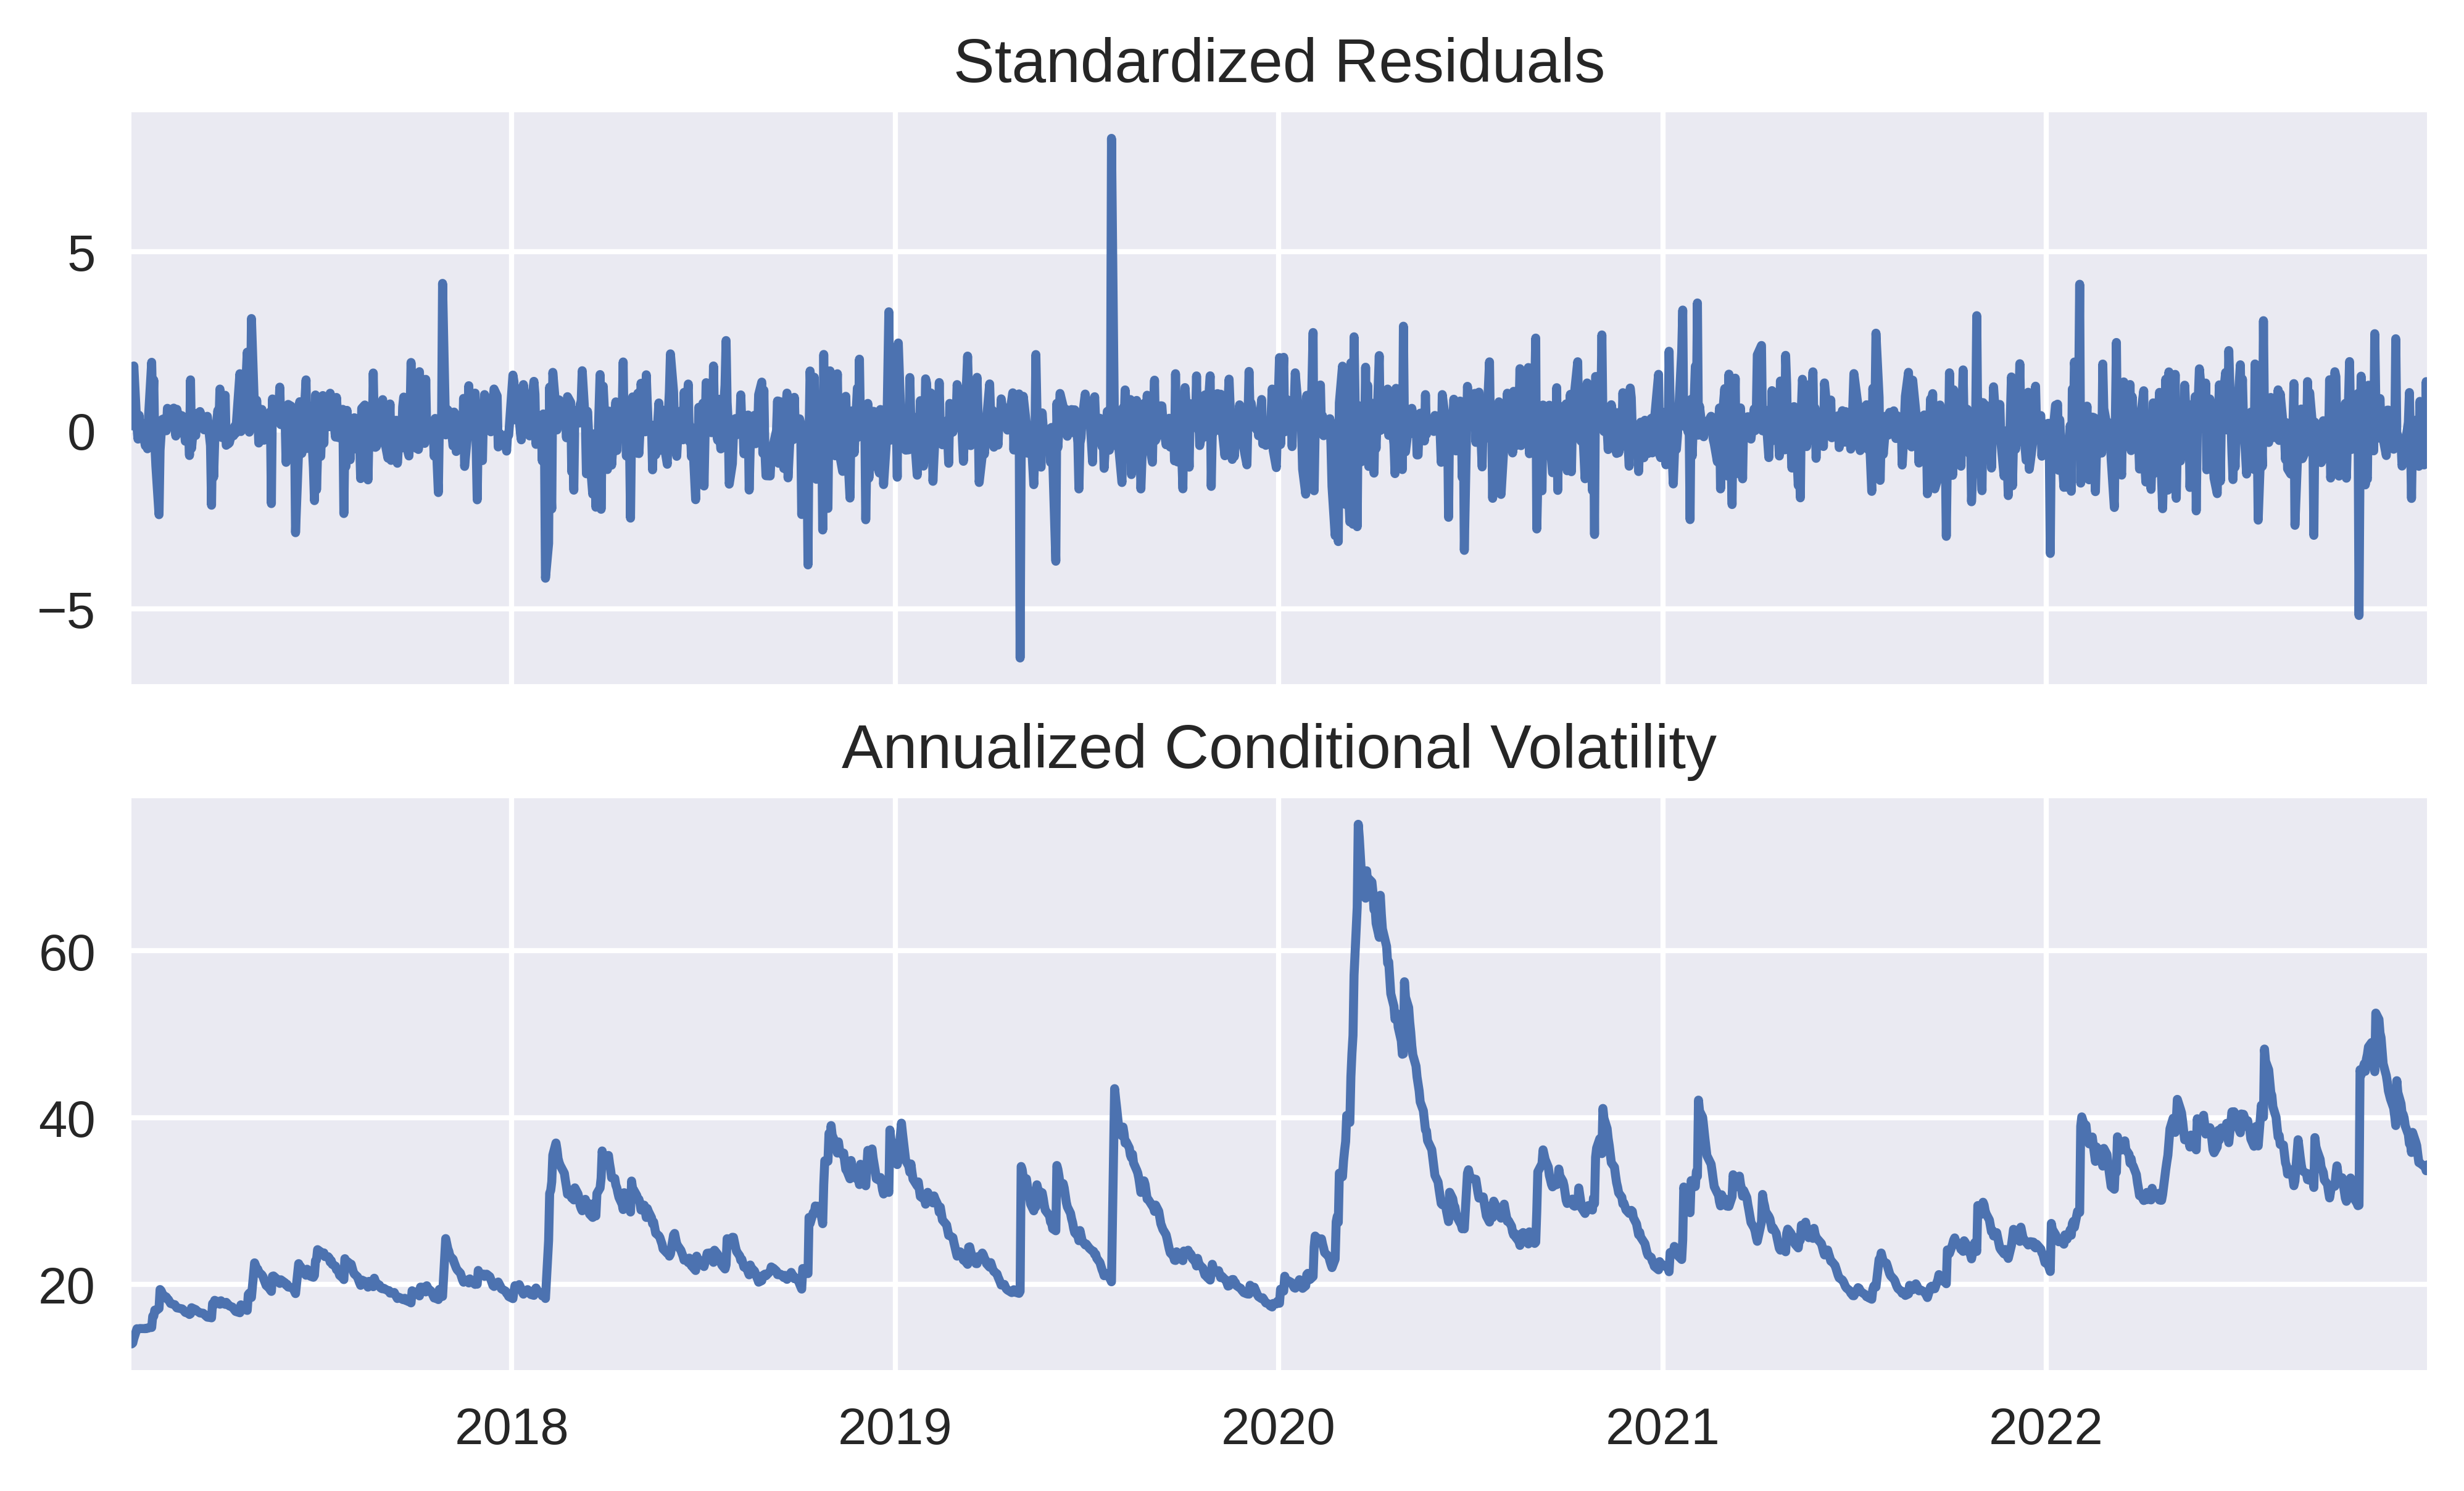

In [21]:
#plot the standardized residuals and conditional variance
result2.plot(annualize='D')

- With ARCH model, the series data in conditonal variance graph shows **more spikes**, then **immediately** returns to the low level.
- With GARCH model, with **moving average effect** included(lagged conditional volatility), it **takes longer time to return** to the level observed before the spike.

### Extensions to GARCH Model
GJR-GARCH:
  - takes the asymmetry of the returns into account
  - **Negative returns** trend to have **stronger impact** on **volatility** than positive ones.
 
EGARCH(exponential), TGARCH(threshold), FIGARCH(Fractionally integrated, with non-stationary data)

- GARCH-MIDAS: decomposed into short-term and long-term component

### Errors Distribution
1. Student T-distribution
2. Skew-t distribution 
3. Generalized Error Distribution (GED)
4. Skewed Generalized Error Distribution (SGED)

But not in normal distribution.



## CCC-GARCH: Constant Conditonal Correlation-GARCH
- Intuition: constant N univariate GARCH models, related to each other with a constant conditional correlation matrix $R$
- Model:
  - $r_t=\mu+ϵ_t$
    - $r_t$: return series, expressed as a vector of return$r_t=(r_{1t},r_{2t},...,r_{nt})$, which is similar as $ϵ_t$
  - $ϵ_t \sim N(0,\sum_t)$, with given $\sum_{t-1}$
  - $\sum_t=D_tRD_t=H_t$
    - Decomposition of <u>conditional covariance matrix</u>
      - R: correlation matrix $R=D_t^{-1}H_tD_t^{-1}=E_{t-1}(ϵ_tϵ_t')$
      - D: diagonal matrix with vector$(\sigma_1,\sigma_2,...,\sigma_k)'$, where $\sigma_i$ is the *std* of i-th series.
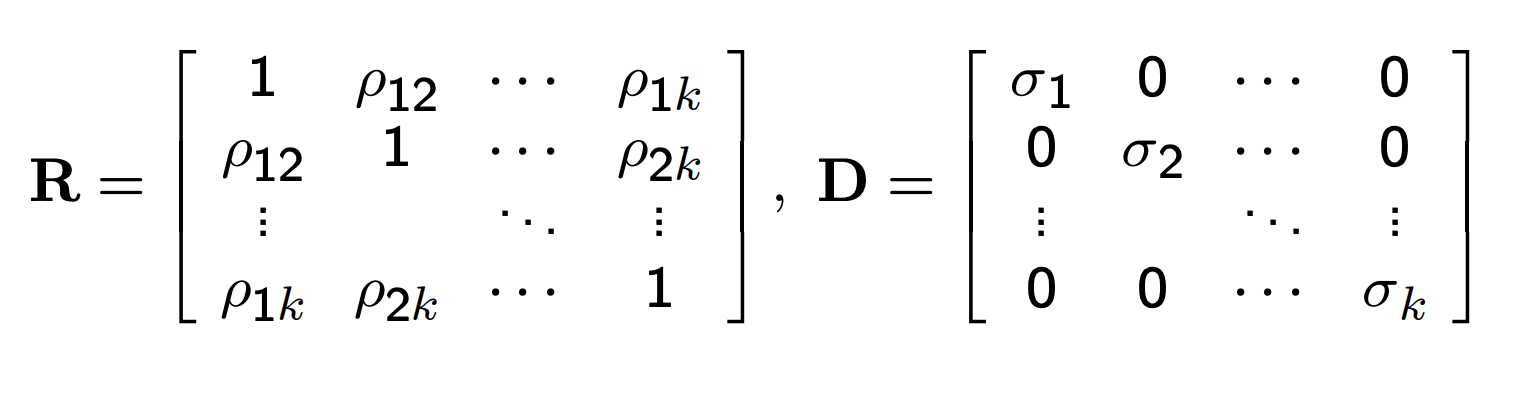 
      - Diagonal: with GARCH(p,q) process, it may estimated using `Maximum Likehood`.
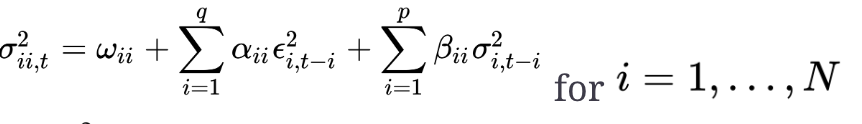

- **Conditional Correlation** between $r_1$ and $r_2$ with $\mu=0$: $\rho_{12,t}=\frac{E_{t-1}(r_{1,t}r_{2,t}}{\sqrt[2]{E_{t-1}(r_{1,t}^2)E_{t-1}(r_{2,t}^2)}}$
  - range:$[-1,1]$
  - based on past information
      - Off-Diagonal: $\sigma_{ij,t}^2=\rho_{i,j}\sigma_{ii,t}\sigma_{jj,t}$, for $i≠j$
  - Individual conditional variances follow `GARCH(1,1)` model.

In [22]:
riskyAssets = ['GOOG', 'MSFT', 'AAPL']
N= len(riskyAssets)
SD = '2017-01-01'
ED = '2022-12-31'

In [23]:
StockPrice = yf.download(riskyAssets,start=SD, end=ED,progress=False)

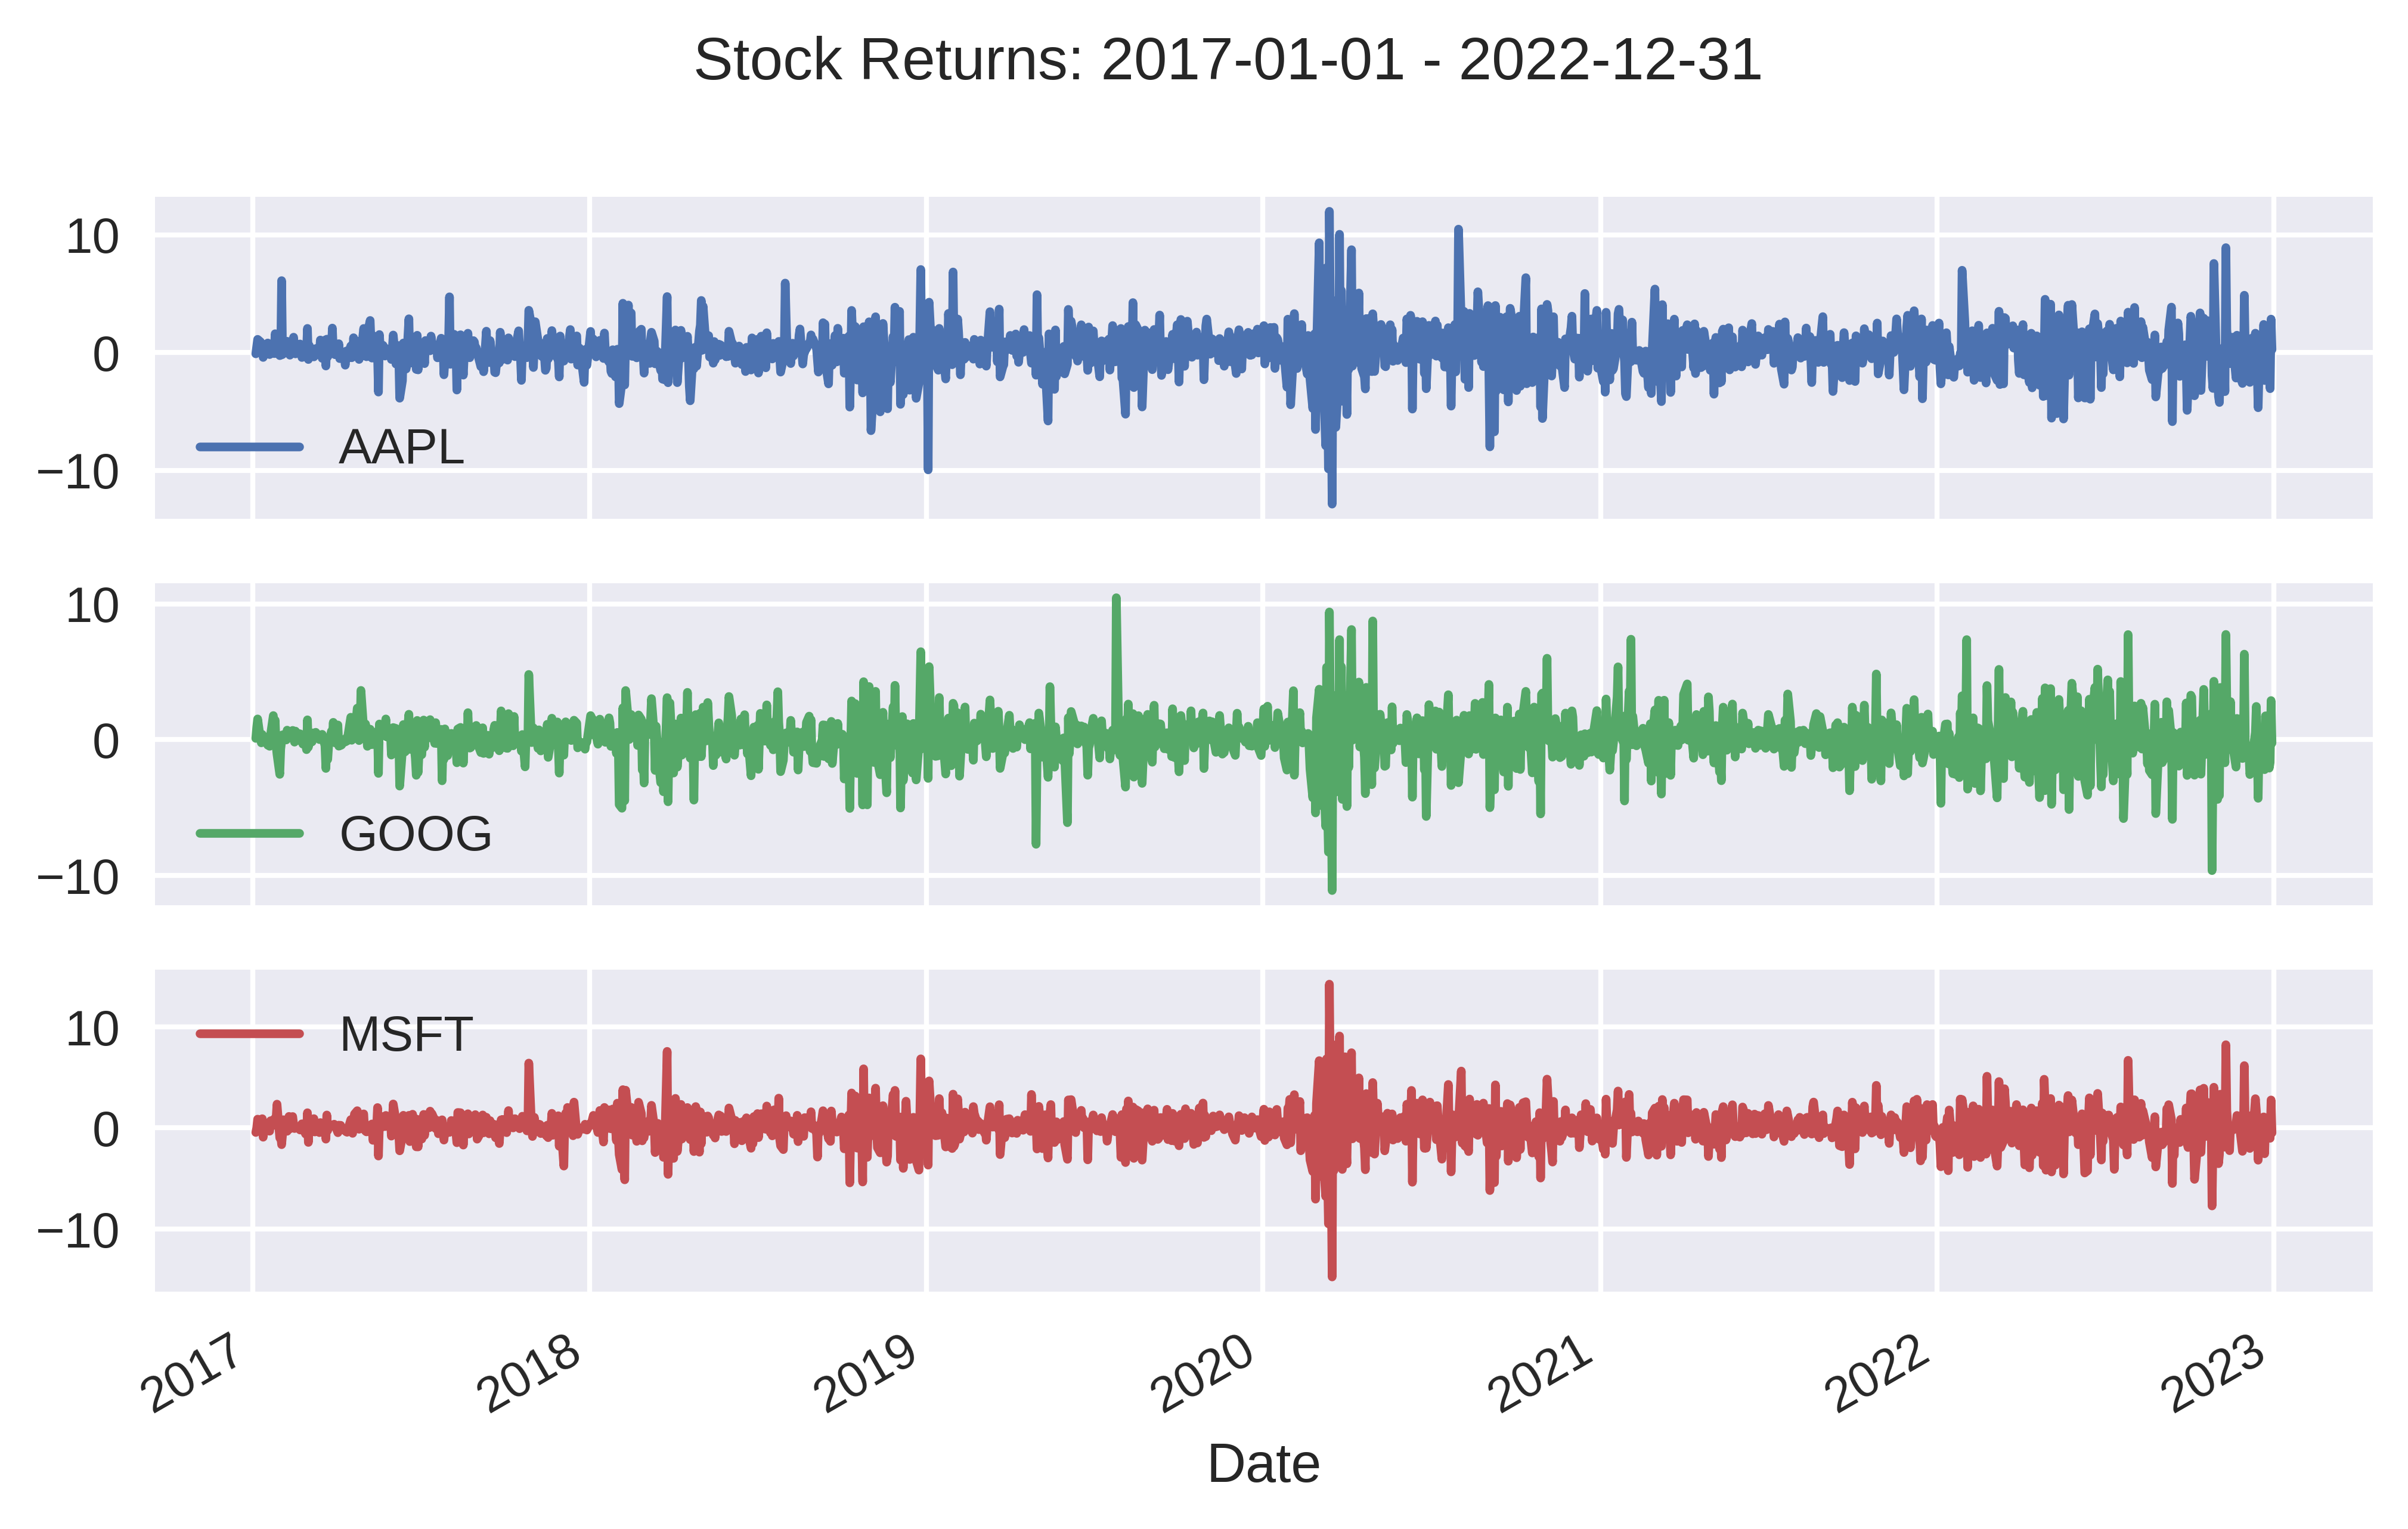

In [24]:
#get the daily returns and plot
returns = 100 * StockPrice['Adj Close'].pct_change().dropna()
returns.plot(subplots=True, title=f'Stock Returns: {SD} - {ED}');

In [25]:
returns.head()

AAPL      GOOG      MSFT
Date                                    
2017-01-04 -0.111931  0.096680 -0.447424
2017-01-05  0.508538  0.904814  0.000000
2017-01-06  1.114821  1.527666  0.866776
2017-01-09  0.915940  0.062027 -0.318269
2017-01-10  0.100861 -0.230589 -0.031932

In [26]:
#define lists for storing elements we use later
coeffs = []
cond_vol = []
std_resids = []
models = []

In [27]:
#estimate GARCH model
for asset in returns.columns:
  GARCH=arch_model(returns[asset], mean='Constant', vol='GARCH', p=1, o=0, q=1).fit(update_freq=0, disp='off') #build the model
  coeffs.append(GARCH.params)
  cond_vol.append(GARCH.conditional_volatility)
  std_resids.append(GARCH.resid / GARCH.conditional_volatility)
  models.append(GARCH)

In [28]:
#store results in dataframes and set index
coeffs_df = pd.DataFrame(coeffs, index=returns.columns)

In [29]:
#adjust the axis, store in a dataframe
cond_vol_df = pd.DataFrame(cond_vol).transpose().set_axis(returns.columns, axis='columns',inplace=False)

In [30]:
std_resids_df = pd.DataFrame(std_resids).transpose().set_axis(returns.columns,axis='columns',inplace=False)

In [31]:
coeffs_df

mu     omega  alpha[1]   beta[1]
AAPL  0.216699  0.149015  0.122893  0.840652
GOOG  0.112567  0.056450  0.054012  0.930151
MSFT  0.152644  0.103167  0.141347  0.829110

In [32]:
cond_vol_df.head()

AAPL      GOOG      MSFT
Date                                    
2017-01-04  1.046252  0.795805  0.767022
2017-01-05  1.040433  0.803451  0.801153
2017-01-06  1.034161  0.831141  0.799138
2017-01-09  1.071080  0.898417  0.839487
2017-01-10  1.083286  0.898534  0.847831

In [33]:
std_resids_df.head()

AAPL      GOOG      MSFT
Date                                    
2017-01-04 -0.314102 -0.019963 -0.782335
2017-01-05  0.280498  0.986055 -0.190530
2017-01-06  0.868455  1.702599  0.893628
2017-01-09  0.652837 -0.056254 -0.560953
2017-01-10 -0.106932 -0.381906 -0.217704

**Formula:** $R=\frac{1}{T}\sum_{t=1}^T z_tz_t'$
- unconditional correlation matrix of $z_t$
- $z_t$: time t standardized residuals from GARCH model

In [34]:
#calculate the constant conditional correlation matrix(R)
R=std_resids_df.transpose().dot(std_resids_df).div(len(std_resids_df))

In [35]:
R.head()

AAPL      GOOG      MSFT
AAPL  0.998236  0.602991  0.639937
GOOG  0.602991  0.998087  0.715751
MSFT  0.639937  0.715751  0.998845

In [36]:
#make forecast H_{t+1}
diagnal = [] #use this list to store forecasted conditional variance later 
D = np.zeros((N, N)) #create a zero matrix with N*N
#populate the list with conditional variance
for model in models:
    diagnal.append(model.forecast(horizon=1).variance.values[-1][0])
#take the squre root to obtain voliatility from variance
diagnal = np.sqrt(np.array(diagnal))
np.fill_diagonal(D, diagnal) #placed the elements of diagonal list on diagonal of matrix D
#calculate the conditional covariance matrix
H = np.matmul(np.matmul(D, R.values), D) #obtained the one-step-ahead forecast using matrix multiplication 

In [37]:
print(H)

[[4.35861193 2.66442337 2.27828153]
 [2.66442337 4.46312318 2.57875254]
 [2.27828153 2.57875254 2.89950226]]


## Forcasting the Conditional Covariance Matrix using DCC-GARCH: Dynamic Conditional Correlation-GARCH
- The conditional correlation is not constant but time varying, it is written as $R_t$
- The process to establish the DCC-GARCH model:
  1. estimate `GARCH model` for <u>conditional volatility</u>
  2. Estimate the `DCC model` for <u>conditional correlations</u>

### DCC Equation:
- $R_t=diag(Q_t)^{-1/2} Q_t diag(Q_t)^{-1/2}$
  - capture the relationship between conditional correlation matrix $R_t$ and proxy process $Q_t$
- $Q_t=(1-γ-\delta)\bar{Q}+γz_{t-1}z'_{t-1}+\delta Q_{t-1}$
  - dynamic of proxy process
- $\bar{Q}=\frac{1}{T}\sum_{i=1}^T z_tz_t'$
  - *unconditional correlation matrix* of standardized residuals from GARCH
  - correlation targeting: efficiently reduce the parameters we need to estimate to only 2(γ,$\delta$).
- $H_t=D_tR_tD_t$
- $ϵ_t=D_t^{-1}r_t$
- in R we already have specific package to model DCC-GARCH(`rmgarch`) or CCC-GARCH. And we use `rpy2` library to write R. https://www.rdocumentation.org/packages/rugarch/versions/1.4-9 

In [39]:
!pip install rpy2==3.5.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached rpy2-3.5.1-cp39-cp39-linux_x86_64.whl


In [40]:
%load_ext rpy2.ipython

In [44]:
%%R
install.packages('rmgarch')

(as ‘lib’ is unspecified)
























	‘/tmp/Rtmpkmqg7Q/downloaded_packages’



In [48]:
%%R
library(rugarch)


Attaching package: ‘rugarch’



    sigma




In [49]:
#import dataset into R programming
%%R -i returns
print(head(returns))

                          AAPL        GOOG        MSFT
2017-01-04 00:00:00 -0.1119314  0.09668002 -0.44742369
2017-01-05 00:00:00  0.5085379  0.90481378  0.00000000
2017-01-06 00:00:00  1.1148214  1.52766609  0.86677570
2017-01-09 00:00:00  0.9159395  0.06202698 -0.31826887
2017-01-10 00:00:00  0.1008611 -0.23058902 -0.03193248
2017-01-11 00:00:00  0.5373175  0.38768387  0.91024710


In [83]:
returns.to_csv("returns.csv")

In [70]:
#model specifications for GARCH(1,1) and DCC(1,1)
#https://search.r-project.org/CRAN/refmans/rugarch/html/ugarchspec-methods.html
# specify GARCH(1,1) model
%%R -i returns
library(rugarch)
univariate_spec <- ugarchspec(mean.model = list(armaOrder = c(0,0)), 
                              variance.model = list(garchOrder = c(1,1), model = "sGARCH"), 
                              distribution.model = "norm")

In [76]:
%%R -i returns
univariate_spec 


*---------------------------------*
*       GARCH Model Spec          *
*---------------------------------*

Conditional Variance Dynamics 	
------------------------------------
GARCH Model		: sGARCH(1,1)
Variance Targeting	: FALSE 

Conditional Mean Dynamics
------------------------------------
Mean Model		: ARFIMA(0,0,0)
Include Mean		: TRUE 
GARCH-in-Mean		: FALSE 

Conditional Distribution
------------------------------------
Distribution	:  norm 
Includes Skew	:  FALSE 
Includes Shape	:  FALSE 
Includes Lambda	:  FALSE 



In [72]:
%%R -i returns
n <- dim(returns)[2]

In [80]:
get_ipython().run_cell_magic(
"R",
"-i returns",
'''
library(rugarch)
dcc_spec <- dccspec(uspec = multispec(n, univariate_spec)),
                    dccOrder=c(1,1),
                    distribution = "mvnorm")
'''
)

RParsingError: ignored

The parsing status gets errors frequently, as a result, we use R to program it.

## BEKK-GARCH

## Pair Trading Stategy